In [1]:
import pandas as pd
import numpy as n
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.18/04


In [2]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta_65p.csv'
dfByTown = pd.read_csv(urlByTown)

urlByTownDaily = 'mortalita_giornaliera_per_citta_65p.csv'
dfByTownDaily = pd.read_csv(urlByTownDaily)

In [3]:
dfByTown.tail()

,Town,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11
11,Roma,484,506,452,480,482,487,527
12,Bari,57,63,53,56,74,78,54
13,Potenza,7,12,8,12,16,8,18
14,Messina,53,48,65,56,50,49,61
15,Palermo,125,152,126,145,133,149,124


In [4]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-01T17:00:00


In [5]:
df={}

provinces = n.unique(dfByTown['Town'])
for p in provinces:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

dfDaily={}

provincesDaily = n.unique(dfByTownDaily['Town'])
for p in provincesDaily:
    dfDaily[p]=dfByTownDaily[dfByTownDaily['Town']==p]
    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
    dfDaily[p]=dfDaily[p].transpose()
    dfDaily[p].columns=['number_of_deaths']
    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)
    #print('---- %s ----'%p)
    #print(dfDaily[p].tail().to_string())

dfPCM={}

for p in provincesDaily:
    dfPCM[p]=dfByProvince[dfByProvince['denominazione_provincia']==p]

for p in n.unique(dfByRegion['denominazione_regione']):
    dfPCM[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

population = pd.read_csv('italianPopulation.csv')
population = population.set_index('Territory')
#population.colums=['population']


In [6]:
dfPCM['Piemonte'].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
705,2020-03-28T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3094,439,3533,3318,6851,504,579,203,617,7671,21511,NaN,NaN
726,2020-03-29T17:00:00,ITA,1,Piemonte,45.073274,7.680687,2985,443,3428,3840,7268,417,535,254,684,8206,24058,NaN,NaN
747,2020-03-30T17:00:00,ITA,1,Piemonte,45.073274,7.680687,2985,452,3437,4218,7655,387,506,308,749,8712,25478,NaN,NaN
768,2020-03-31T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3174,452,3626,4456,8082,427,589,365,854,9301,27658,NaN,NaN
789,2020-04-01T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3146,453,3599,4871,8470,388,494,439,886,9795,30060,NaN,NaN


In [7]:
graphs={}

regions=[
    'Lombardia',
    'Piemonte',
    'Liguria',
    'Veneto',
    'Lazio',
]

townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Roma':'Lazio'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6
}

deathRatio_65p=0.9 #Table1 https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-marzo%202020.pdf

keys=["deceduti","terapia_intensiva","totale_ospedalizzati","nuovi_positivi","dimessi_guariti"]

deathTime=7

for ip,p in enumerate(regions):
    np=population.loc[p,'Population']
    for ik,k in enumerate(keys):
        graphs['%s_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_%s'%(k,p)].SetName('%s_%s'%(k,p))
        for i,ni in enumerate(dfPCM[p][k]):
            graphs['%s_%s'%(k,p)].SetPoint(i,i,float(ni))
            graphs['%s_%s'%(k,p)].SetPointError(i,0,R.TMath.Sqrt(ni))

for p in provincesDaily:
    #print(p)
    graphs['totale_casi_%s'%p]=R.TGraphErrors()
    graphs['totale_casi_%s'%p].SetName("infected_%s"%p)
    
    graphs['estimated_death_town_%s'%p]=R.TGraphErrors()
    graphs['estimated_death_town_%s'%p].SetName("estimated_death_town_%s"%p)

    pop=population.loc[p,'Population']
    sumD=0
    fracPopulation=townPopulation[p]/pop
    for i,ni in enumerate(dfPCM[p]['totale_casi']):
        graphs['totale_casi_%s'%p].SetPoint(i,i+24,ni) #daily series here starts from 0
        graphs['totale_casi_%s'%p].SetPointError(i,0,R.TMath.Sqrt(ni))
        #print(ni)

        if (i>deathTime): #look in the past to estimate fraction of deaths... not ideal
            DD=dfPCM[townRegion[p]]['deceduti'].iloc[i]-dfPCM[townRegion[p]]['deceduti'].iloc[i-1]
            fracP=0.
            nP=0
            for ii in range(i-1-deathTime,i-deathTime+1):
                if (dfPCM[townRegion[p]]['totale_casi'].iloc[ii]>0):
                    fracP+=dfPCM[p]['totale_casi'].iloc[ii]/dfPCM[townRegion[p]]['totale_casi'].iloc[ii]
                    nP+=1
            if(nP>0):
                fracP=fracP/nP
            D=dfPCM[townRegion[p]]['deceduti'].iloc[i]*fracP
            D1=dfPCM[townRegion[p]]['deceduti'].iloc[i-1]*fracP
            newD=D-D1    
            ed=newD*fracPopulation
            sumD+=ed
            graphs['estimated_death_town_%s'%p].SetPoint(i-8,i+23,ed)
    print(p,i+23,'%d %.1f %d %.2f %.1f'%(dfPCM[townRegion[p]]['deceduti'].iloc[i],sumD,DD,fracP,ed))

Brescia 60 7593 202.9 394 0.20 12.5
Genova 60 460 122.5 32 0.33 7.4
Milano 60 7593 440.7 394 0.19 30.6
Torino 60 886 134.6 32 0.46 5.8


In [8]:
# # of usable days in the last week according to Table1. Do we really need to scale last week??
lastWeekDays={
    'Aosta':5.,
    'Bolzano':5.,
    'Brescia':4.,
    'Torino':7.,
    'Milano':5.,
    'Genova':6.,
    'Bologna':6.,
    'Verona':5.,
    'Venezia':4.,
    'Roma':4.,
    'Civitavecchia':6.,
    'Bari':5.,
    'Potenza':6.,
    'Perugia':4.,
    'Messina':7.,
    'Palermo':4.
}

In [9]:
df['Roma'].tail()

,number_of_deaths
Week 7,452
Week 8,480
Week 9,482
Week 10,487
Week 11,527


In [10]:
#Fill Root TGraphErrors
for p in provinces:
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
                                    
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale)
        graphs['deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(24)
    graphs['deceduti_%s'%p].SetMarkerSize(0.9)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*7*(x-5))',0,100)
    graphs['deceduti_%s'%p].Fit('fB','RQB+','',5,8.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale-graphs['deceduti_%s'%p].GetFunction('fB').Eval(i+5))
        graphs['eccesso_deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(0.9)
                                                                  

In [11]:
for p in provincesDaily:
    graphs['deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['deceduti_giornalieri_%s'%p].SetName('deceduti_giornalieri_%s'%p)                               
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        #print(i,dfDaily[p]['number_of_deaths'][i])
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_giornalieri_%s'%p].SetPoint(i,i,(dfDaily[p]['number_of_deaths'][i])*scale)
        graphs['deceduti_giornalieri_%s'%p].SetPointError(i,0,R.TMath.Sqrt((dfDaily[p]['number_of_deaths'][i])*scale))
    print('---- %s #data:%d ----'%(p,graphs['deceduti_giornalieri_%s'%p].GetN()))
    graphs['deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerStyle(24)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerSize(0.9)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*x)',0,100)
    graphs['deceduti_giornalieri_%s'%p].Fit('fB','RQB+','',0,27.5) #fit february data as baseline

    graphs['eccesso_deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetName('eccesso_deceduti_giornalieri_%s'%p)
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPoint(i,i,dfDaily[p]['number_of_deaths'][i]*scale-graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Eval(i))
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPointError(i,0,R.TMath.Sqrt(dfDaily[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerSize(0.9)

---- Brescia #data:49 ----
---- Genova #data:50 ----
---- Milano #data:49 ----
---- Torino #data:50 ----


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Use

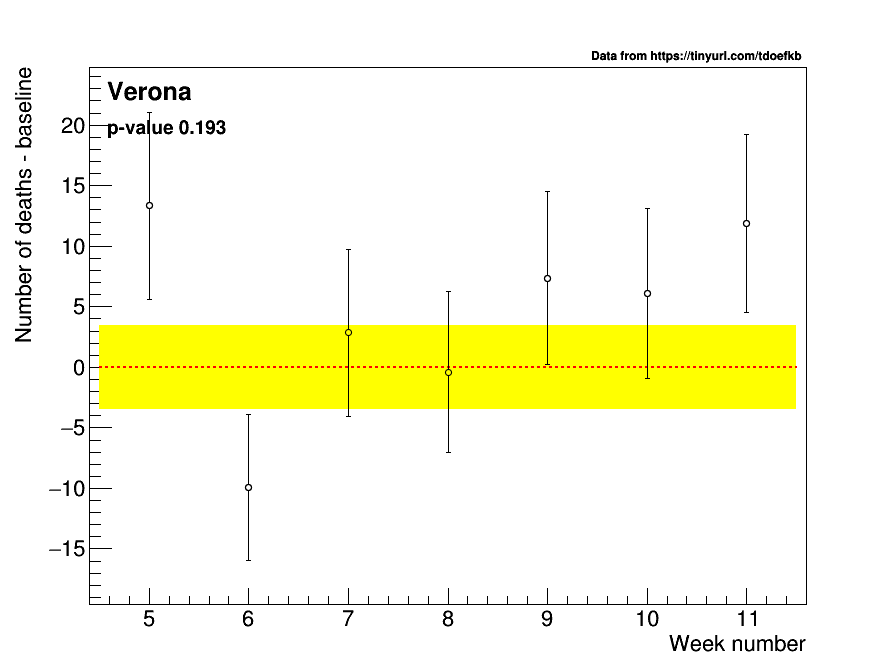

In [12]:
c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

for p in provinces:
    graphs['eccesso_deceduti_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(4.5,0,11.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()

    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
    
    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_%s'%p].Fit('f0','RB0Q','')
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    if (f0.GetProb()>=1E-3):
        t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
    else:
        t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}".format(p)+ext)



Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_B

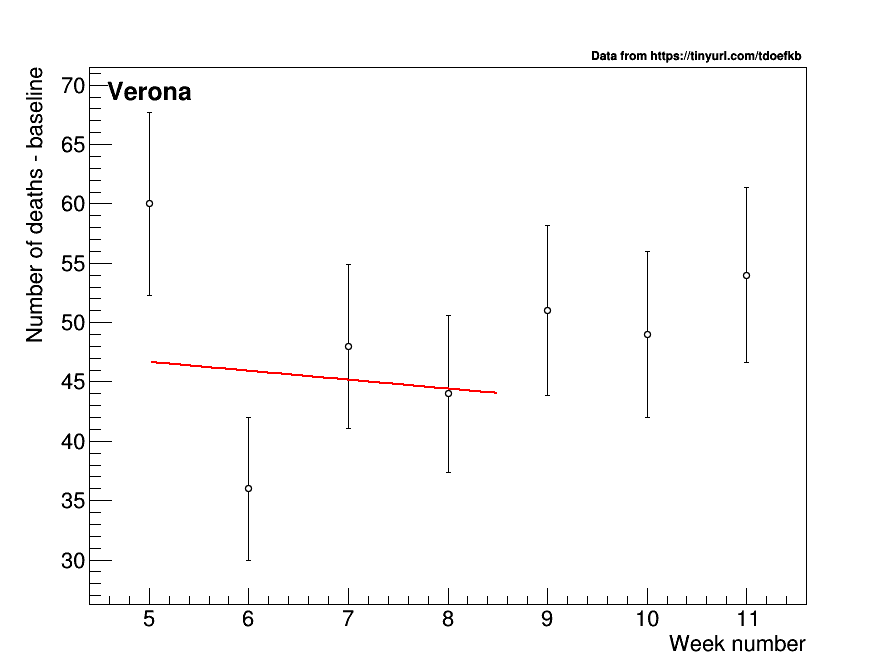

In [19]:
for p in provinces:
    graphs['deceduti_%s'%p].Draw("APSAME")
    graphs['deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    #baseline=graphs['deceduti_%s'%p].GetFunction('fB').GetParameter(0)
    #baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    #box=R.TBox(4.5,baseline-baseline_stdev,11.5,baseline+baseline_stdev)
    #box.SetFillColor(R.kYellow)
    #box.Draw()
    #line=R.TLine(4.5,baseline,11.5,baseline)
    #line.SetLineColor(R.kRed)
    #line.SetLineStyle(2)
    #line.SetLineWidth(2)
    #line.Draw()

    graphs['deceduti_%s'%p].Draw("PSAME")
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/death_{:s}".format(p)+ext)

 FCN=61.4199 FROM MIGRAD    STATUS=CONVERGED     146 CALLS         147 TOTAL
                     EDM=4.64271e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -3.20628e+01   7.83719e-01  -3.40607e-06   1.71097e-03
   2  p1           6.00000e+00   2.63658e-01  -1.19391e-03** at limit **
 FCN=59.5301 FROM MIGRAD    STATUS=CONVERGED      80 CALLS          81 TOTAL
                     EDM=4.9704e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -2.78485e+01   5.98320e-01   2.36368e-05  -5.13109e-02
   2  p1           6.00000e+00   3.87360e-01   2.10835e-03** at limit **
 FCN=79.1828 FROM MIGRAD    STATUS=CONVERGED      93 CALLS          94 TOTAL
                 

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Brescia.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Brescia.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Brescia.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Genova.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Genova.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Genova.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Milano.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcessDaily_Milano.png has been

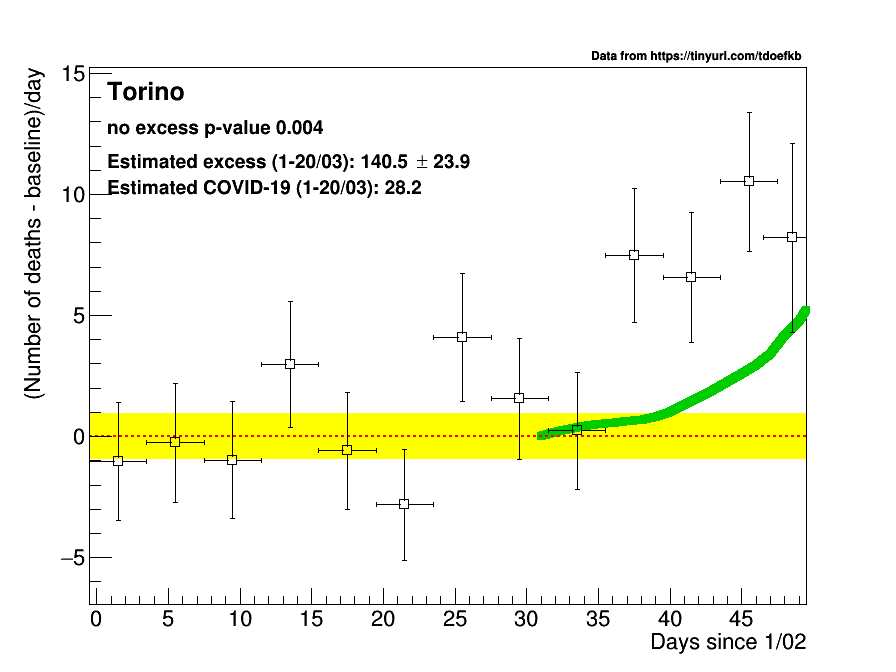

In [14]:
logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)


def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        w2=1/(g.GetErrorY(i)*g.GetErrorY(i))
        average_Y+=y*w2
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/sumw2
            average_X=average_X/ibin
            err_Y=R.TMath.Sqrt(1/sumw2)
            err_X=r/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

smooth=R.TGraphSmooth()
for p in provincesDaily:
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    graphs['eccesso_deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth.SmoothSuper(rebinned,'')

    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("(Number of deaths - baseline)/day")

    baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)

    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("PSAME")
    smoothedExt=smooth.SmoothSuper(graphs['estimated_death_town_%s'%p],'')
    graphs['estimated_death_town_%s'%p].SetLineColor(R.kGreen+1)
    graphs['estimated_death_town_%s'%p].SetLineWidth(8)
    #graphs['estimated_death_town_%s'%p].Draw("LSAME")
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    smoothedExt.Draw("LSAME")
    line.Draw()
    #f.Draw('LSAME')

    totalExcess=integralGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],31)
    expectedExcess=integralGraph(graphs['estimated_death_town_%s'%p],0,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-31)
    ratio=totalExcess[0]/expectedExcess[0]
    f1=R.TF1('f1','[2]*TMath::Exp((x+[0])/[1])',0,100)
    f1.SetParameter(0,f.GetParameter(0))
    f1.SetParameter(1,f.GetParameter(1))
    f1.SetParameter(2,1/ratio)
    f1.SetLineColor(R.kRed)
    f1.SetLineStyle(2)
    f1.SetLineWidth(2)
    #f1.Draw('LSAME')
    
    rebinned.Draw("PSAME")

    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_giornalieri_%s'%p].Fit('f0','RB0Q','')
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    if (f0.GetProb()>=1E-3):
        t.DrawLatexNDC(0.12,0.8,'no excess p-value %.3f'%f0.GetProb())
    else:
        t.DrawLatexNDC(0.12,0.8,'no excess p-value < 0.001')

    t.DrawLatexNDC(0.12,0.75,'Estimated excess (1-20/03): %.1f #pm %.1f'%(totalExcess[0],totalExcess[1]))
    t.DrawLatexNDC(0.12,0.71,'Estimated COVID-19 (1-20/03): %.1f'%expectedExcess[0])
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessDaily_{:s}".format(p)+ext)

In [18]:
fOut=R.TFile('~/cernbox/www/plots/COVID19_DA/graphs.root','RECREATE')
for o,g in graphs.items():
    g.Write()
fOut.Write()
fOut.Close()